# Before running this code
1. Combine the temperature data by `CombineTwoCsvFile.py`
2. Select the start time and end time in the combined temperature file, record the line number and type them into `start_row` and `end_row`

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as dt
from matplotlib.dates import strpdate2num
from wanglab_instruments.wanglab_instruments.utils import helpers as h
import os
import datetime
import math
from matplotlib import dates

In [39]:
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Reading the temperature data

Start time is:   8:58:00.887
End time is:   9:49:49.809
Number of Skipping_temps data =  1452


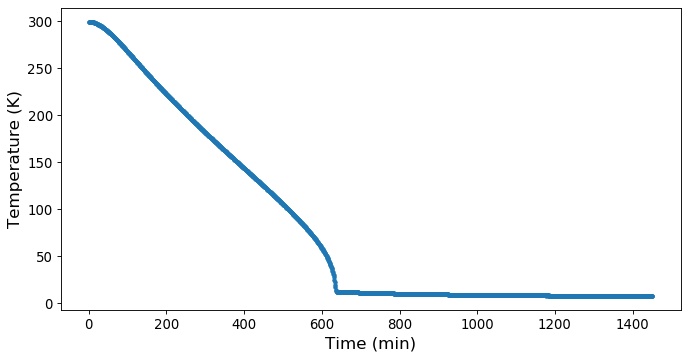

In [41]:
#spectrum analyzer data
folder = 'CoolDownApr28/'
_format = '%Y%m%d_%H%M%S.npy'

#temperature data
filename = 'MI_TempDataLog 04_28_2021.csv'
start_row = 52
end_row = 39232
diff = end_row-start_row
interval = 27 
#the spectrum data have different time intervals from temperature data, the 'interval' here is the difference.
#temp_times = np.loadtxt(filename, delimiter=",", converters = {1: lambda s: float(s.replace(":",""))}, skiprows=start_row-1, usecols=1)[:diff]
temp_times = np.loadtxt(filename, dtype = 'str', delimiter=",", skiprows=start_row-1, usecols=1)[:diff] 
temp_temps = np.loadtxt(filename, delimiter=",", skiprows=start_row-1, usecols=3)[:diff] 

print('Start time is: ',temp_times[0]) 
print('End time is: ',temp_times[-1])# Check the start and end time
skipping_temps = temp_temps[::interval]
skipping_times = temp_times[::interval]
print('Number of Skipping_temps data = ',len(skipping_temps))


plt.figure(figsize=(10, 5), dpi=80)
plt.subplot(1,1,1)
plt.plot(skipping_temps, '.')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (K)')
plt.show()

# Reading the spectrum data

In [13]:
plot_every = 2 # plot the reflection curves every other n data
#avg_int = 2*60 #avg data within 2 min intervals
#end_index = 10000
data_list = []
data_times = []
times = []

for root, dirs, fils in os.walk(folder):
    for fil in fils:
        data_list.append(np.load(os.path.join(root,fil)))
        data_times.append(fil.strip('.npy'))
        times.append(datetime.datetime.strptime(fil,_format))

print('Number of spectrum data = ',len(data_list))

nn = min(len(skipping_temps),len(data_list))
print('The final number of analyzed data is ', nn)
# To understand the data structure
'''for i in range(len(data_list)):
    if i>0:
        break
    print('data(i,0) = ',data_list[i][0])
    print('data(i,1) = ',data_list[i][1])
    print('data_times = ',data_times[i])
    print('times = ', times[i])   '''

Number of spectrum data =  1462
The final number of analyzed data is  1452


"for i in range(len(data_list)):\n    if i>0:\n        break\n    print('data(i,0) = ',data_list[i][0])\n    print('data(i,1) = ',data_list[i][1])\n    print('data_times = ',data_times[i])\n    print('times = ', times[i])   "

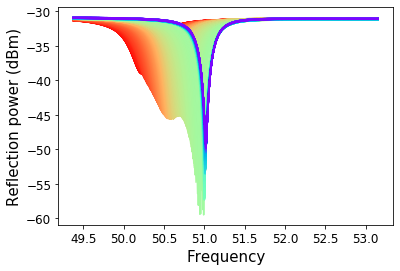

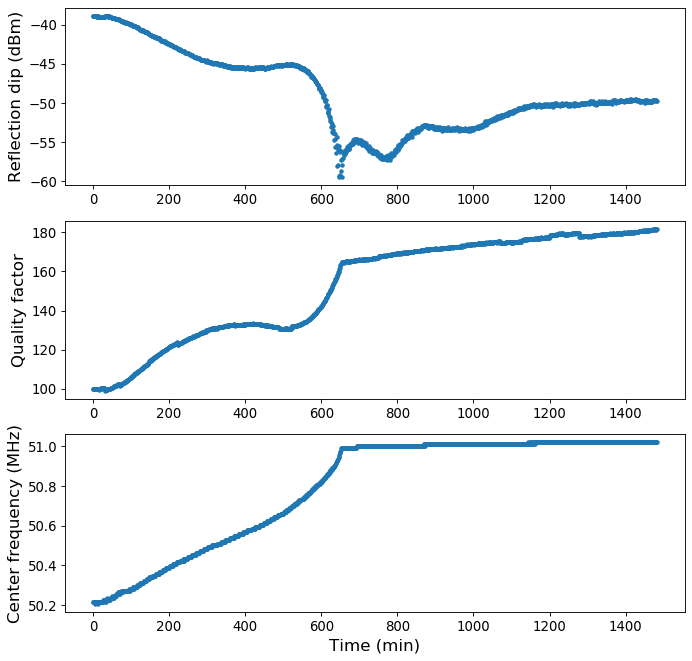

In [42]:
# Analyze the minimun dip, quality factor and central frequency
mins = []
freqs = []
Qs = []

for i in range(len(data_list)):
    xdat = data_list[i][0] # The swapping frequencies at given time snapshot
    ydat = data_list[i][1] # The reflection data at every frequency at given time snapshot
    baseline = ydat[0]
    mins.append(np.min(ydat))
    freqs.append(xdat[ydat==np.min(ydat)][0]) #find minimum of reflection dip, record freq
    popt, pcov = h.fit_lorentzian(xdat, h.unlog(ydat),x0=freqs[-1],
                        amp =-1)
    Qs.append(np.abs(popt[0]/popt[-1]))

mins = np.array(mins) 
Qs = np.array(Qs)
freqs = np.array(freqs)

## When reading the files in the folder, the reading order is wired, so we need to re-order the data by time
tsort = np.array(sorted(range(len(times)), key=lambda k: times[k])) # get keys to sort all data by times

times_sorted = [times[i] for i in tsort] #sort all data by times, these times are still datetime objects
mins_sorted = [mins[i] for i in tsort]
freqs_sorted = [freqs[i] for i in tsort]
Qs_sorted = [Qs[i] for i in tsort]
data_sorted = [data_list[i][:] for i in tsort]

dt = []  #find the total time elapsed from start, in seconds (type: float)

# Plot spectrum lines at the chronological order
colors = cm.rainbow(np.linspace(0, 1, math.ceil(len(times_sorted)/plot_every + 5)))
plot = 0
#for i in range(len(times_sorted)-5):
for i in range(len(times_sorted)-5):
    dt.append((times_sorted[i] - times_sorted[0]).total_seconds())

    if i%plot_every == 0: #plot every nth curve
        plot += 1
        plt.plot(data_sorted[i][0],data_sorted[i][1], color = colors[-plot])
plt.xlabel("Frequency")
plt.ylabel("Reflection power (dBm)") #check these
plt.show()

#nn = len(dt)-5

plt.figure(figsize=(10, 10), dpi=80)
dtmin = [x / 60 for x in dt]
plt.subplot(3,1,1)
plt.plot(dtmin[:nn],mins_sorted[:nn], '.')
plt.ylabel('Reflection dip (dBm)')

plt.subplot(3,1,2)
plt.plot(dtmin[:nn], Qs_sorted[:nn], ".")
plt.ylabel('Quality factor')

plt.subplot(3,1,3)
plt.plot(dtmin[:nn], freqs_sorted[:nn], '.')
plt.xlabel('Time (min)')
plt.ylabel('Center frequency (MHz)')

plt.show()

# Plot analyze vs. temperature

[299.428 299.425 299.405 ...   7.64    7.645   7.659]


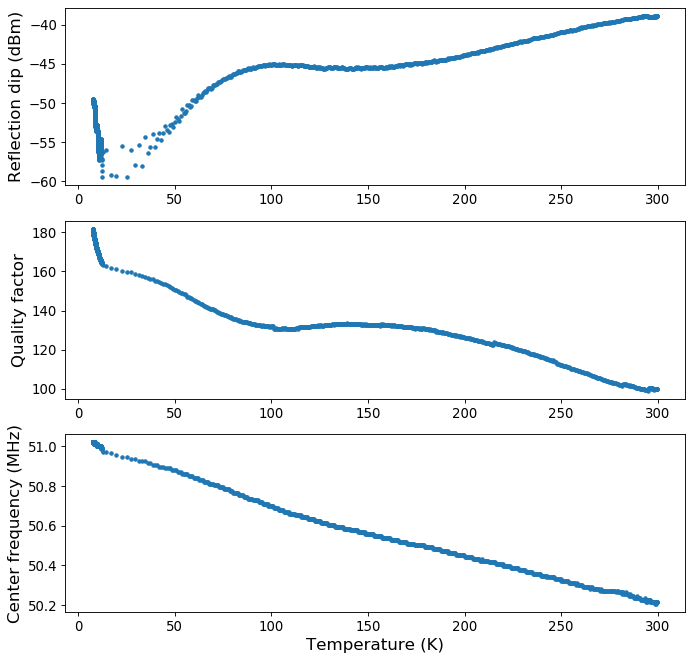

In [38]:
print(skipping_temps)

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(10, 10), dpi=80)
#temp analysis
plt.subplot(3,1,1)
plt.plot(skipping_temps[:nn], mins_sorted[:nn], '.')
plt.ylabel('Reflection dip (dBm)')

plt.subplot(3,1,2)
plt.plot(skipping_temps[:nn], Qs_sorted[:nn], ".")
plt.ylabel('Quality factor')

plt.subplot(3,1,3)
plt.plot(skipping_temps[:nn], freqs_sorted[:nn], '.')
plt.xlabel('Temperature (K)')
plt.ylabel('Center frequency (MHz)')

plt.show()

# Save the data as csv

In [43]:
import csv

with open('CoolDownApr28.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Temperature (K)', 'Minimum dip (dBm)', 'Quality factor (Q)', 'Central frequency (MHz)'])
    writer.writerows(zip(skipping_temps[:nn], mins_sorted[:nn], Qs_sorted[:nn], freqs_sorted[:nn]))